# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors. 

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [20]:
import sys
import numpy as np
from matplotlib import pyplot
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

In [460]:
np.random.seed(42)

print("Loading hdf files...")

tcga_h5_pathname = "data/tcga_target_gtex_train.h5"
msigdb_gmt_pathname = "data/c2.cp.kegg.v6.1.symbols.gmt"    # Needs a login to download from URL. Must be hosted locally

x = pd.read_hdf(tcga_h5_pathname, "expression")
x.head()

y = pd.read_hdf(tcga_h5_pathname, "labels")
y.head()

# Generate a set object from all of the TCGA gene symbols
tcga_gene_set = set(x.columns.values)

gene_sets = dict()

# Load gene sets from downloaded MSigDB gmt file (KEGG gene sets)
with open(msigdb_gmt_pathname) as file:
    for line in file:
        line = line.strip().split('\t')
        set_name = line[1]
        kegg_gene_subset = set(line[2:])

        # Find genes that are in both the KEGG database AND the TCGA dataset (AKA the intersection)
        genes = kegg_gene_subset & tcga_gene_set

        # Store the sets in their separate categories (just in case we want to subset by category later)
        gene_sets[set_name] = genes


print("Loaded %d gene sets" % len(gene_sets))

# Find the union of all genes in the gene sets
all_gene_set_genes = sorted(list(set.union(*[gene_set for gene_set in gene_sets.values()])))

print("Subsetting to %d genes" % len(all_gene_set_genes))

# Prune x so that it only contains the genes that are in both TCGA and KEGG
x_pruned = x.drop(labels=(set(x.columns)-set(all_gene_set_genes)), axis=1, errors="ignore")

assert x_pruned["TP53"]["TCGA-ZP-A9D4-01"] == x["TP53"]["TCGA-ZP-A9D4-01"]

m,n = x_pruned.shape                # m = number of training examples
print("x_pruned shape: ", m, n)

# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(x_pruned.columns.values)
assert list(x_pruned.columns.values) == all_gene_set_genes

x_array = np.array(x_pruned.values, dtype=np.float32)

# extract primary site names from data table
y_names = list(set(y["primary_site"].values))
y_names = sorted(y_names)

y_array = np.zeros(shape=(m, len(y_names)), dtype=np.float32)

# create a key for converting names to indices
y_index_key = {name:i for i,name in enumerate(y_names)}

# generate one-hot vectors for all primary site y data
for m,primary_site_name in enumerate(y["primary_site"].values):
    index = y_index_key[primary_site_name]
    y_array[m,index] = 1

# split data into training and testing set with equal class representation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(x_array, y_array):
    x_train, x_test = x_array[train_index], x_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

print("Training set x dimensions: ", x_train.shape)
print("Training set y dimensions: ", y_train.shape)
print("Testing set x dimensions: ", x_test.shape)
print("Testing set y dimensions: ", y_test.shape)
print(y.head())

# ensure that the output directory exists
if not os.path.exists("data/"):
    os.mkdir("data/")

# save the data in compressed numpy files
np.savez_compressed("data/x_train.npz", a=x_train)
np.savez_compressed("data/y_train.npz", a=y_train)
np.savez_compressed("data/x_test.npz", a=x_test)
np.savez_compressed("data/y_test.npz", a=y_test)

Loading hdf files...
Loaded 186 gene sets
Subsetting to 5172 genes
x_pruned shape:  15300 5172
Training set x dimensions:  (12240, 5172)
Training set y dimensions:  (12240, 46)
Testing set x dimensions:  (3060, 5172)
Testing set y dimensions:  (3060, 46)
                                                               category  \
id                                                                        
GTEX-12ZZW-0011-R6a-SM-5DUVZ  Brain - Nucleus Accumbens (Basal Ganglia)   
GTEX-131YS-0005-SM-5NQAS                                    Whole Blood   
TCGA-VQ-A8PD-01                                  Stomach Adenocarcinoma   
TCGA-3H-AB3T-01                                            Mesothelioma   
GTEX-111VG-2326-SM-5N9BK                         Adipose - Subcutaneous   

                                                                disease  \
id                                                                        
GTEX-12ZZW-0011-R6a-SM-5DUVZ  Brain - Nucleus Accumbens (Basal Gangli

## Part 1

1. There are 5172 genes with 15300 expression entries each.
2. 20% of the complete data set has been witheld for testing ('test_size = 0.2').
3. Each sample will be classified from 12240 expression values in training.
4. There are 46 tissue types
5. Each expression vector can be potentially classified into 46 different tissue of origin classes. Size of the output layer should be 46. 
6. The Dataset class includes a method that checks provided indeces against the PyTorch tensors.

## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [22]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

## train_batch

Method to calculate loss values for 2 passes over the dataset (forward and backprop), called by train method. Compares forward pass to target value and calculates forward loss, zeroes the the gradients to run backprop on clean variables to calculate loss backwards. Update optimizer parameters.
Input: See train()
Output: loss value for current batch

In [158]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    #loss = loss_fn(y_predict, y)
    # convert 1-hot vectors back into indices
    max_values, target_index = y.max(dim=1)
    target_index = target_index.type(torch.LongTensor)
    loss = loss_fn(y_predict, target_index)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
            
    

    return y, y_predict, loss.data[0]

## train

Iterates through dataset epoch number of times, calls on train batch method for loss calculation.
Input: model generated in ShallowLinear, shuffled training data from DataLoader method, defined optimization method, defined loss function (MSE), number of iterations through training set desired
Output: List of loss values computed from each epoch

In [415]:
def train(model, loader, optimizer, loss_fn, epochs=17):
    losses = list()
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            x = Variable(x)
            y = Variable(y)

            y, y_predict, loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1
        
            y_vectors.append(y.data.numpy())
            y_predict_vectors.append(y_predict.data.numpy())
            
        print("Epoch: ", e+1)
        print("Batches: ", batch_index)
    
        y_predict_vector = np.concatenate(y_predict_vectors)
        y_vector = np.concatenate(y_vectors)


    return y_predict_vector, y_vector, losses

## test_batch

Calculate and return predicted values of input y
Input: model, 

In [405]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

## test

Handles I/O for test batch method, returns concatenated vector of all predicted y values.

In [406]:
def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        x = Variable(x)
        y = Variable(y)

        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)
    y_vector = np.concatenate(y_vectors)

    return y_vector, y_predict_vector

## plot_loss

Plot loss against epoch progression, visualizes losses as they improve (minimize) or otherwise change with optimization.

In [407]:
def plot_loss(losses, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()

## ShallowLinear

Class to instantiate and define the topology of the neural network. Returns activated model.

In [408]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        # Can increase layers (H2, H3)
        D_in, H1, H2, H3, D_out = [5172,64,64,64,46]    # These numbers correspond to each layer: [input, hidden_1, output]
        
        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)


    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = F.relu(x)       # activation function
        
        x = self.linear2(x) # hidden layer
        x = F.relu(x)       # activation function
        
        x = self.linear3(x) # hidden layer
        x = F.relu(x)       # activation function

        x = self.linear4(x) # output layer
        
        x = F.log_softmax(x, dim=1)
        
        return x

## run

Calls on defined functions to train and test the model on the provided dataset. Returns both the loss and the predicted values.

In [438]:
def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 16
    
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-2
    shallow_model = ShallowLinear()
    
    # Initialize the optimizer with above parameters
    optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    #loss_fn = nn.MSELoss()  # mean squared error
    loss_fn = nn.CrossEntropyLoss() # cross entropy loss

    # Train and get the resulting loss per iteration
    yp_train, y_train, loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn)
    
    # Test and get the resulting predicted y values
    y, y_predict = test(model=shallow_model, loader=data_loader_test) #3.2

    return loss, y, y_predict, yp_train, y_train #3.2


## Diagram

![title](Diag1.jpeg)

## 2.3

Train set size:  12240
Test set size:  3060
Epoch:  1
Batches:  765
Epoch:  2
Batches:  1530
Epoch:  3
Batches:  2295
Epoch:  4
Batches:  3060
Epoch:  5
Batches:  3825
Epoch:  6
Batches:  4590
Epoch:  7
Batches:  5355
Epoch:  8
Batches:  6120
Epoch:  9
Batches:  6885
Epoch:  10
Batches:  7650
Epoch:  11
Batches:  8415
Epoch:  12
Batches:  9180
Epoch:  13
Batches:  9945
Epoch:  14
Batches:  10710
Epoch:  15
Batches:  11475
Epoch:  16
Batches:  12240
Epoch:  17
Batches:  13005
True Y Vectors: (3060, 46)
Y Predict Vectors: (3060, 46)
Final loss: 0.057711713329481426


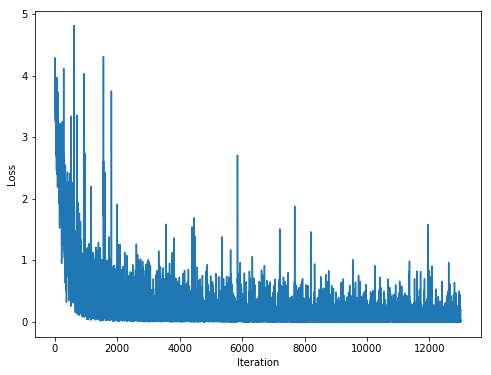

In [439]:
x_train_path = "data/x_train.npz"
y_train_path = "data/y_train.npz"
x_test_path = "data/x_test.npz"
y_test_path = "data/y_test.npz"

dataset_train = PrimarySiteDataset(x_path=x_train_path,
y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path,
y_path=y_test_path)

print("Train set size: ", dataset_train.length)
print("Test set size: ", dataset_test.length)

losses, y, y_predict, yp_train, y2_train = run(dataset_train=dataset_train, dataset_test=dataset_test)

print('True Y Vectors:', y.shape)  #3.2
print('Y Predict Vectors:', y_predict.shape)  #3.2

print("Final loss:", sum(losses[-100:])/100)
plot_loss(losses)

## 3.1

Final loss is currently ~0.022, layers are: IN: 5172, H1: #, OUT:46. These were the layers that I used to get run() to execute successfully, nothing else is changed.

## 3.2

Dimensions of both Y and Y_predict vectors are [3060,46]

## 3.3

No, these dimensions do not match training set size from part 1 ([12240, 46])

## 3.4

In [440]:
print('y_predict','y')

# make a column for each vector, with each instance of the first vector
Col = [c for c in y[0]]
ypCol = [yp for yp in y_predict[0]]

#print side by side columns, tab delimited
print("\n".join("{0:.3f}\t{1:.0f}".format(a, b) for a, b in zip(ypCol, Col)))

y_predict y
-18.175	0
-15.767	0
-7.632	0
-11.586	0
-0.308	1
-18.477	0
-15.784	0
-18.451	0
-14.458	0
-7.132	0
-7.446	0
-14.188	0
-15.022	0
-7.285	0
-10.250	0
-15.876	0
-14.513	0
-4.924	0
-11.086	0
-3.700	0
-5.415	0
-8.646	0
-1.498	0
-11.931	0
-19.430	0
-20.672	0
-15.292	0
-13.090	0
-16.417	0
-17.178	0
-9.773	0
-12.564	0
-14.379	0
-13.469	0
-19.550	0
-7.952	0
-19.088	0
-10.874	0
-20.151	0
-13.103	0
-6.272	0
-18.768	0
-9.968	0
-10.460	0
-16.235	0
-18.214	0


## 3.5

In [441]:
#find maximium values at each position of the vectors from training output
y_argmax = y.argmax(axis=1)
y_pred_argmax = y_predict.argmax(axis=1)

#print shape of each vector to ensure they have the same number of training examples
print('Y Shape (n,):', y_argmax.shape)
print('Ypred Shape (n,):', y_pred_argmax.shape)

#print first value of both vectors
print('Expected Y Max from example #1:', y_argmax[0])
print('Predicted Y Max from example #1:', y_pred_argmax[0])

n = y_argmax.shape[0]
print(n)

Y Shape (n,): (3060,)
Ypred Shape (n,): (3060,)
Expected Y Max from example #1: 4
Predicted Y Max from example #1: 4
3060


The above maximum values correspond to each of the maximums observed in the table above. They do not match, indicating a lack of accuracy in the model.

## 3.6

In [442]:
y_matches = 0

#iterate through positions in each vector and compare
for m in range(len(y_argmax)):
    if y_argmax[m] == y_pred_argmax[m]:
        y_matches += 1
        
print('Probability of agreeing matches:', y_matches/n)  # where n (defined above) is number of examples


Probability of agreeing matches: 0.9519607843137254


## 3.7

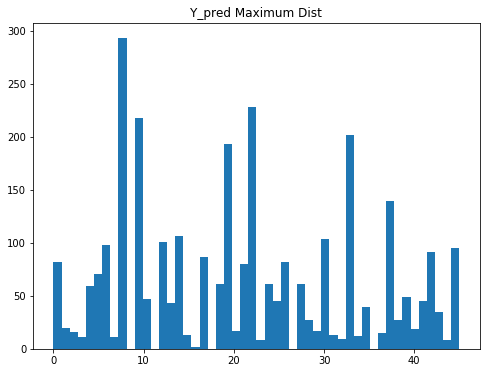

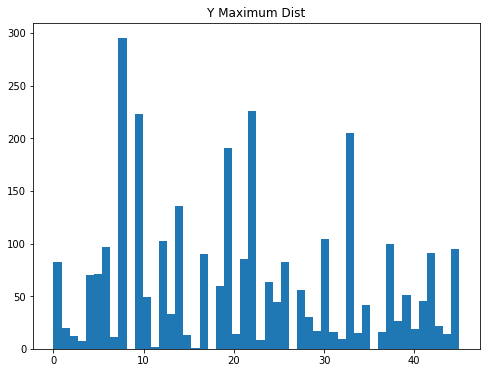

In [446]:
# figure one
fig1 = pyplot.figure()
fig1.set_size_inches(8,6)
pyplot.title('Y_pred Maximum Dist')
pyplot.hist(y_pred_argmax, bins=50)
# figure two
fig2 = pyplot.figure()
fig2.set_size_inches(8,6)
pyplot.title('Y Maximum Dist')
pyplot.hist(y_argmax, bins=50)
# print
pyplot.show()

## Part 5

### Architecture
3 hidden layers at 64 width each using relu activation functions.

### Parameters
Epochs = 17
Learning Rate = 1e-2
Batch Size Train = 16
Optimizer = SGD
Loss Fxn = Cross Entropy Loss
Accuracy = ~95-96

These parameters were hand tuned to the best of my ability. There seems to be a natural interplay between learning rate, batch size, and epoch count that required a fair bit of back and forth to most optimally fit the loss function. relu had the most relaible performance across the activation functions, whereas Adam seemed far worse in my hands than SGD upon switching to CES from MLE.

Loss remained an issue throughout optimization, this would benefit greatly from an automated process. Hand tuning the parameters was fruitful but not efficient.

### Confusion Matrix Thoughts (Plotted Below)
The model seems to perform pretty well across the vast majority of classes, with notable confusion present in closely related tissue: 
* uterus and fallopian/cervix
* colon and rectum


Normalized confusion matrix
[[0.94 0.   0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.82 0.   0.  ]
 [0.   0.   0.   ... 0.29 0.57 0.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]]


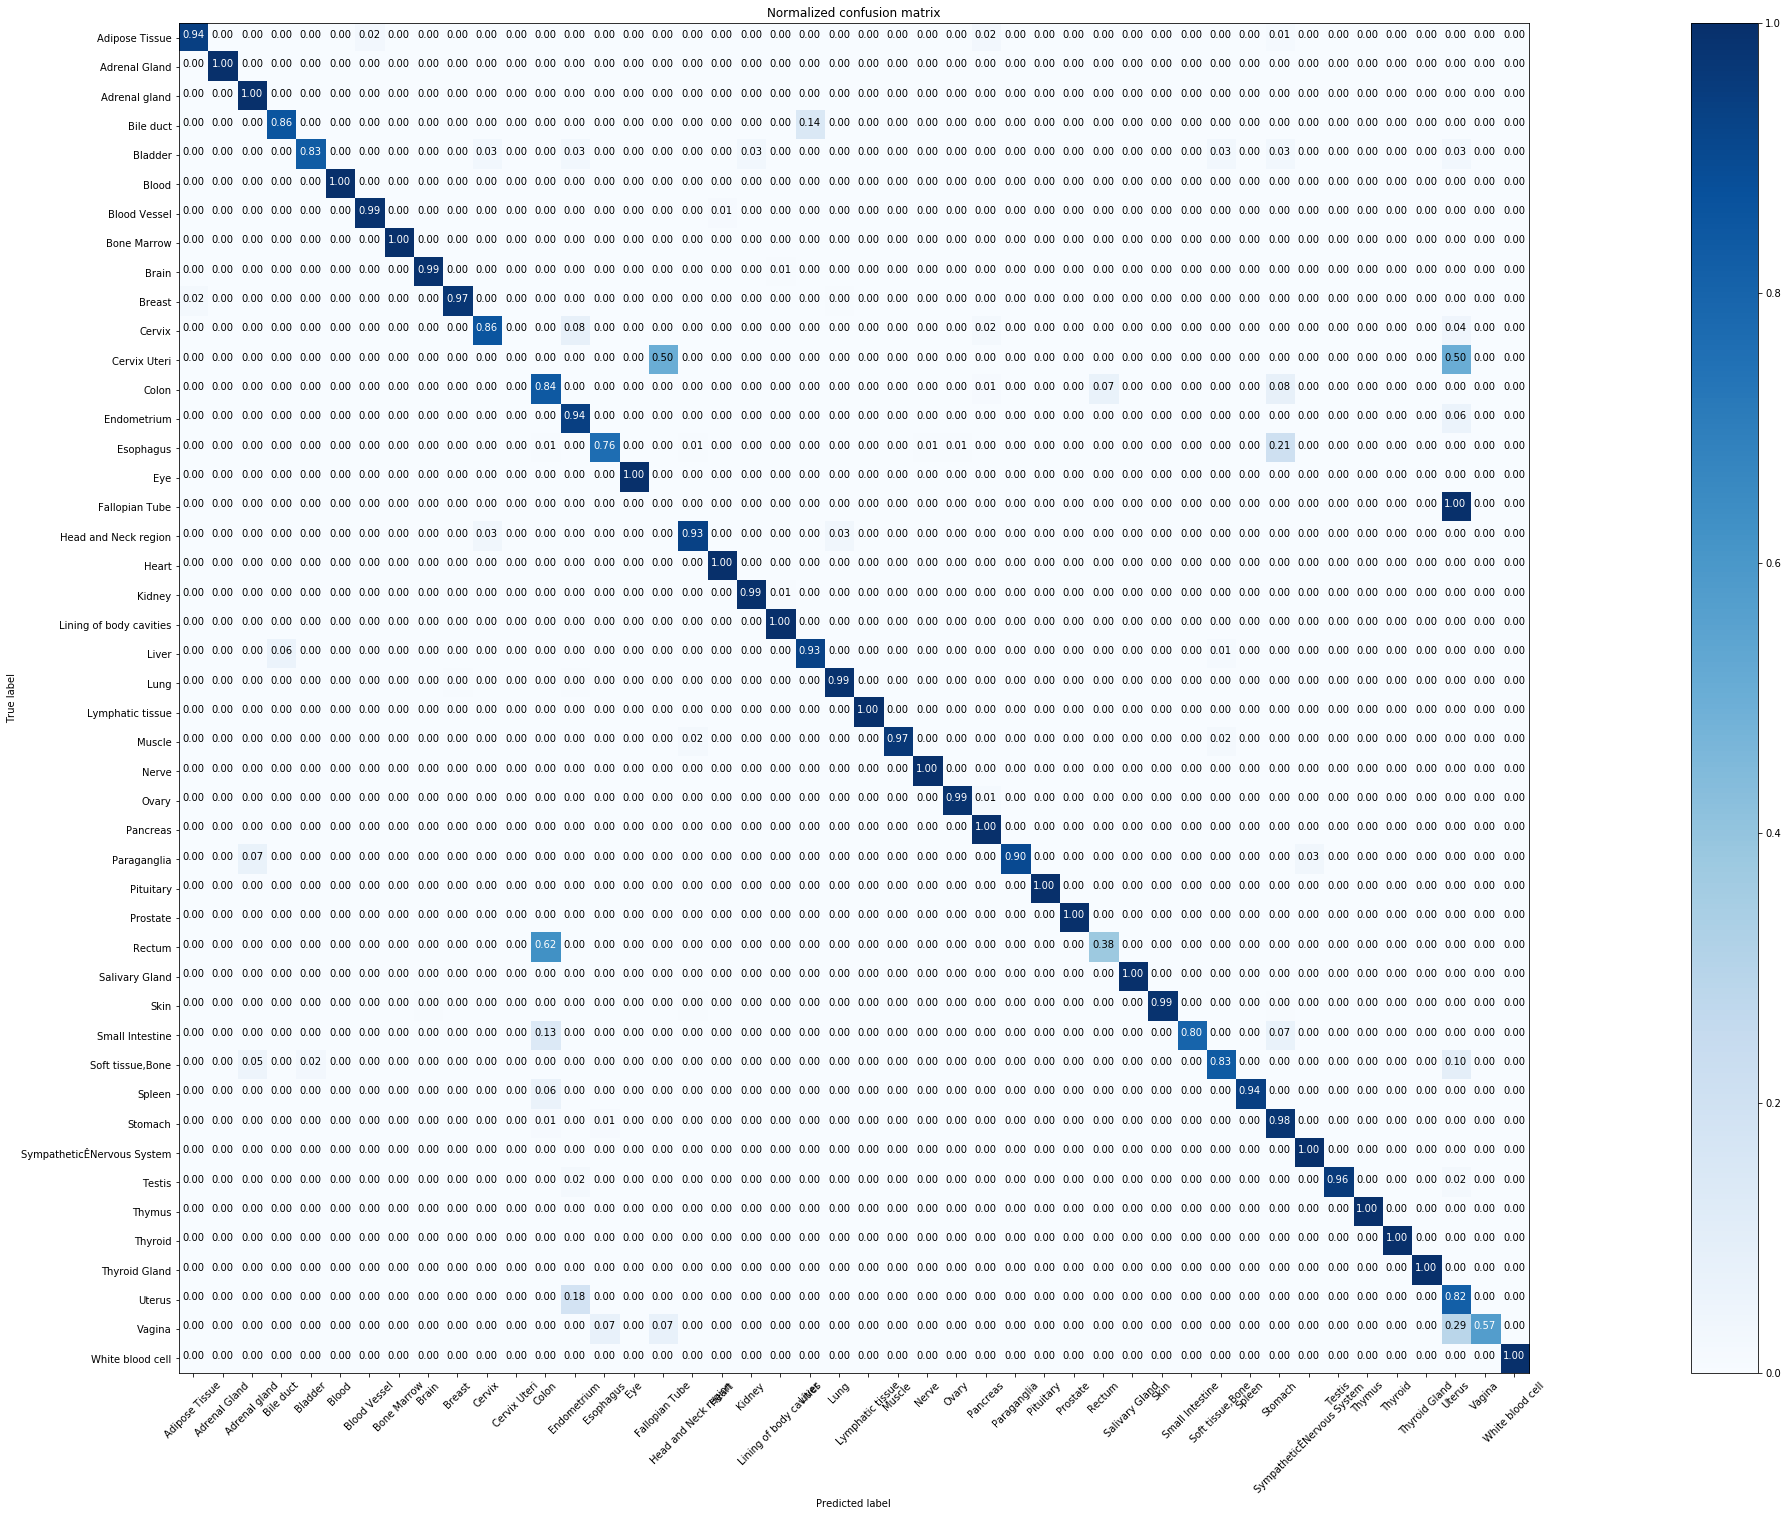

In [458]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# taken from SKlearn website

class_names = y_names

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_argmax, y_pred_argmax)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#pyplot.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
                      #title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig1 = pyplot.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

fig1.set_size_inches(64,42)

pyplot.show()